# A simple example on how to learn a representation on the Nine Rooms environment

In [3]:
import numpy as np
from utils import Random_traj_env, representation_score, wandb_plot
from model import SoftClusterNetwork
from torch import optim
import torch
import matplotlib.pyplot as plt

In [4]:
config = {
    "seed": 0,
    "env": "MiniGrid-NineRoomsDet-v0",
    "load_data": False,
    "p_random_action": 0,
    "max_len_episode": 100,
    "pos_or_image": "image",
    "n_episodes_env": 1000,
    "n_abstract_states": 9,
    "width": 19,
    "height": 19,
    "lr": 1e-4,
    "epochs": 5000,
    "batch_size": 32,
    "wl1": 1,
    "wl2": 0.4,
    "wl3": 0.1
}

In [6]:
# First let's collect some random trajectory data
memory, trajectories_dataset, print_states, annotations = Random_traj_env(config)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


loaded environment
collecting data


100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


tot_n_steps_in_the_env:  101000
total_len_dataset_trajectories = 1000
experience_replay_size = 101000


In [7]:
# set seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# # # Training the network
network = SoftClusterNetwork(config["n_abstract_states"], config["width"], config["height"])
optimizer = optim.AdamW(network.parameters(), lr=config["lr"])


Epoch 0, Loss: (-0.6022347211837769, 0.0718313604593277, -2.1944665908813477, 2.037205457687378)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/utils.py:926: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  a_s_room = network.pred(torch.FloatTensor(room_img), 1).detach().numpy()


Error: 305.5762279033358, Squared Error: 420.6725288698179, Abs Error: 442.80583169311285


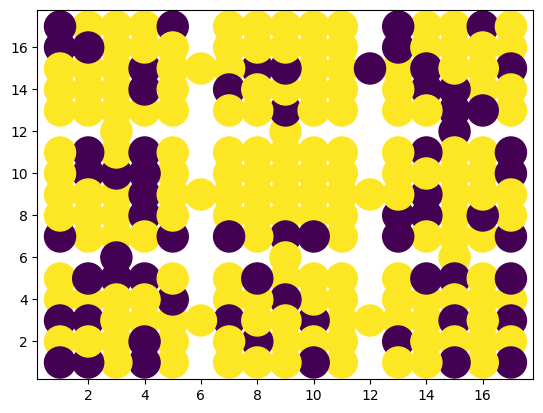

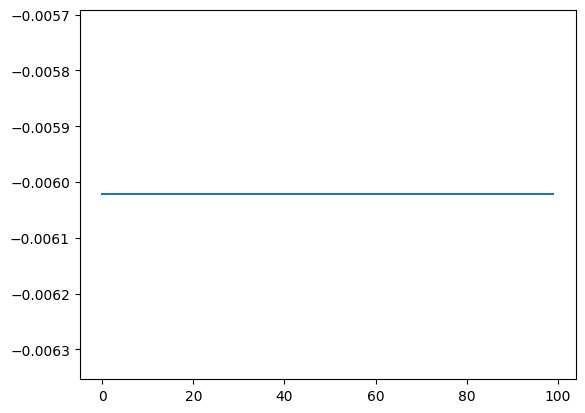

Epoch 100, Loss: (-0.7884922623634338, 0.030321216210722923, -2.17561411857605, 0.5143211483955383)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 186.8805509854174, Squared Error: 236.69765792618188, Abs Error: 274.7392180581519


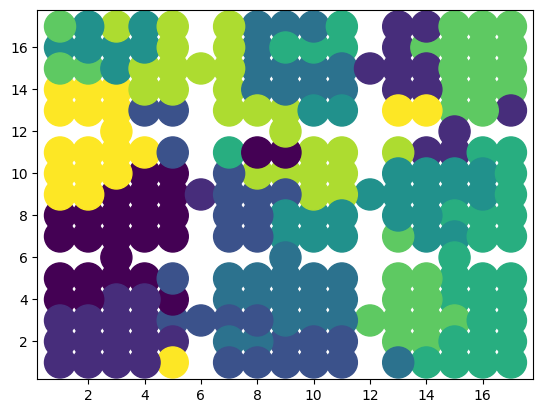

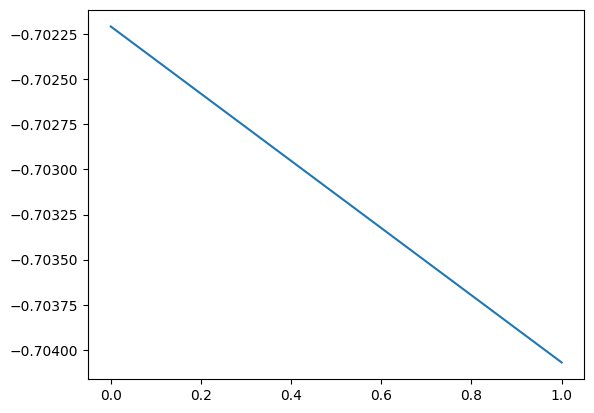

Epoch 200, Loss: (-0.7882300019264221, 0.0363047756254673, -2.174471855163574, 0.45253986120224)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 161.9435452352242, Squared Error: 209.46464862550073, Abs Error: 235.5068245579023


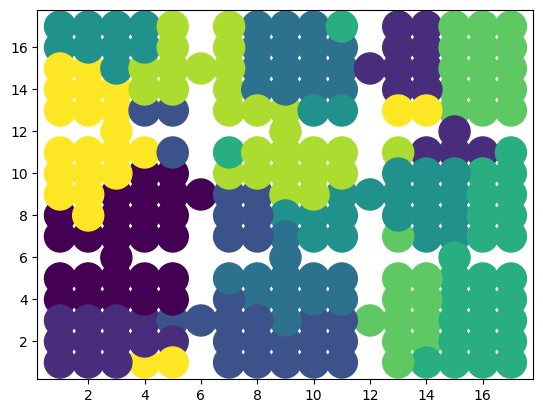

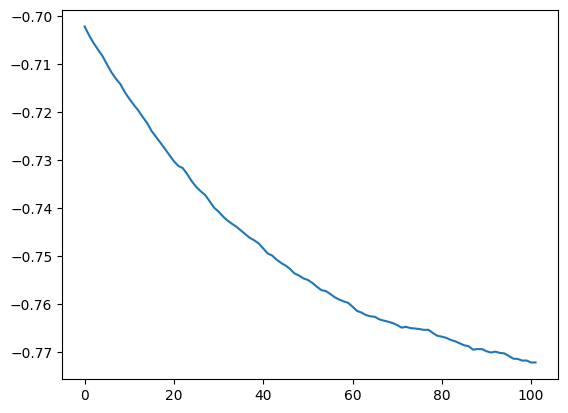

Epoch 300, Loss: (-0.8060182332992554, 0.02144470438361168, -2.135942220687866, 0.2691403031349182)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 162.3133771132433, Squared Error: 212.5386826185178, Abs Error: 234.68449645038345


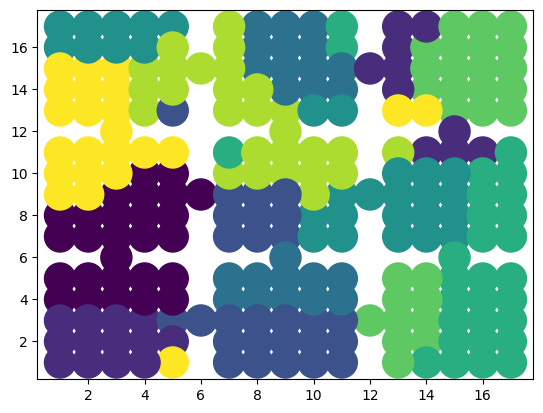

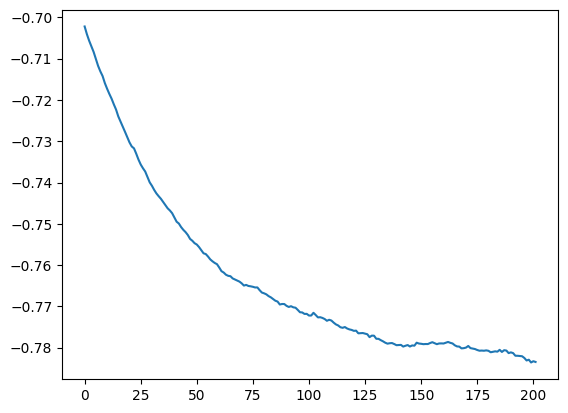

Epoch 400, Loss: (-0.8082799315452576, 0.020729975774884224, -2.1329281330108643, 0.2416139841079712)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 165.40133327382603, Squared Error: 218.96662777627316, Abs Error: 237.68321256517083


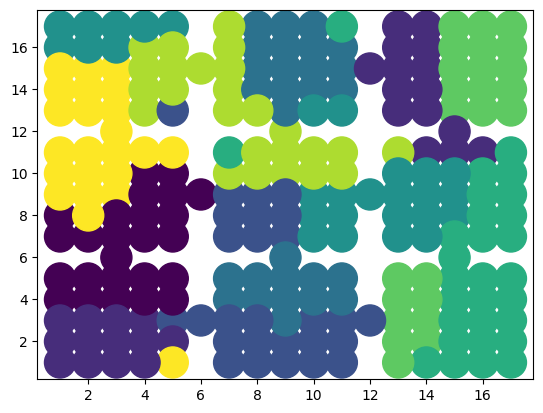

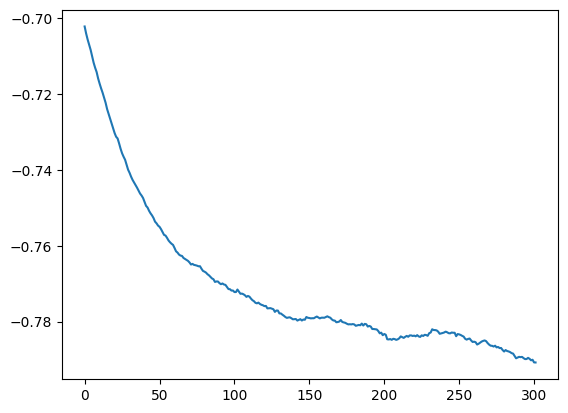

Epoch 500, Loss: (-0.8356231451034546, 0.011231670156121254, -2.161982297897339, 0.1793813854455948)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 166.09855924492172, Squared Error: 221.3997610287406, Abs Error: 237.54548910356243


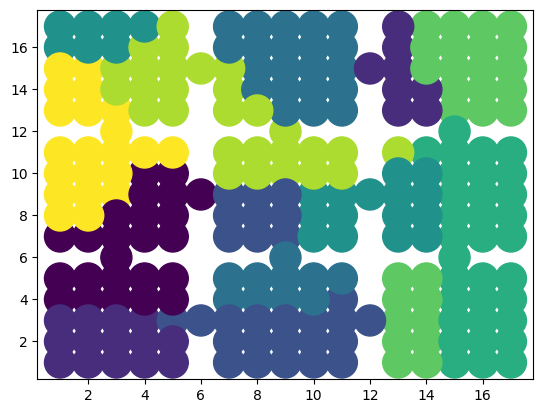

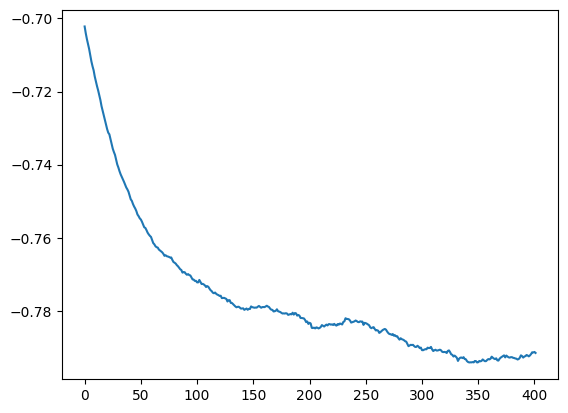

Epoch 600, Loss: (-0.7919481992721558, 0.028445269912481308, -2.107297420501709, 0.2252557873725891)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 170.02993243205322, Squared Error: 228.27977070835334, Abs Error: 242.89726373677695


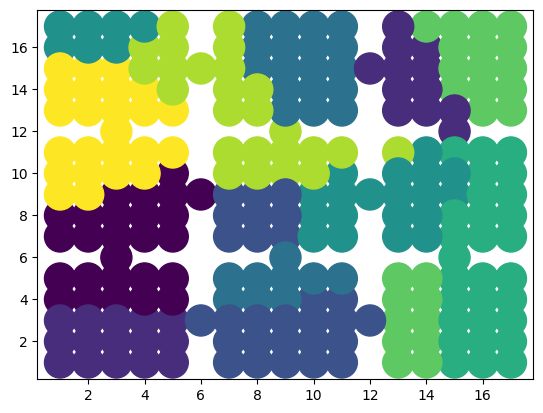

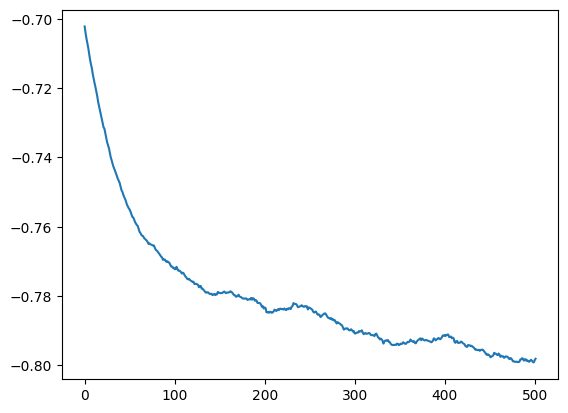

Epoch 700, Loss: (-0.8109830021858215, 0.0194585919380188, -2.1367547512054443, 0.24260313808918)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 152.326188196825, Squared Error: 200.98465683704387, Abs Error: 218.1410157952596


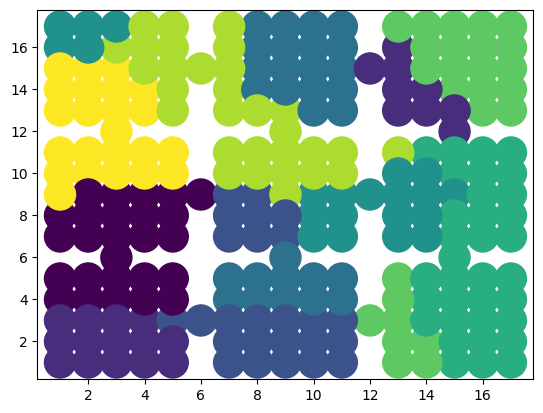

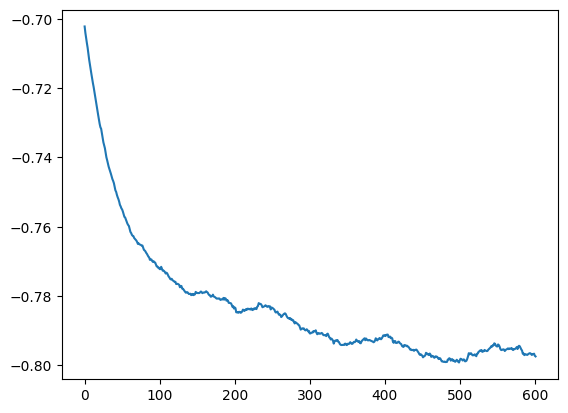

Epoch 800, Loss: (-0.7923049926757812, 0.018467877060174942, -2.100062370300293, 0.29252034425735474)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 121.80250270494274, Squared Error: 154.43813736516805, Abs Error: 174.86194051584243


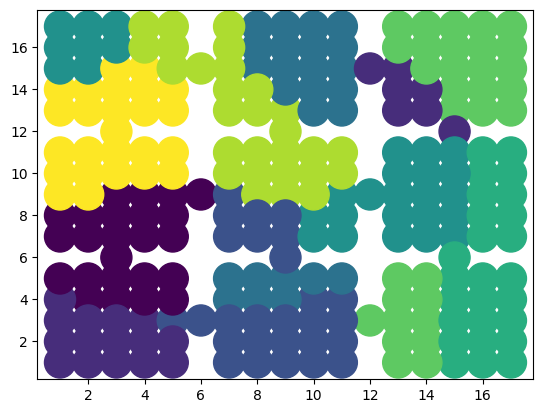

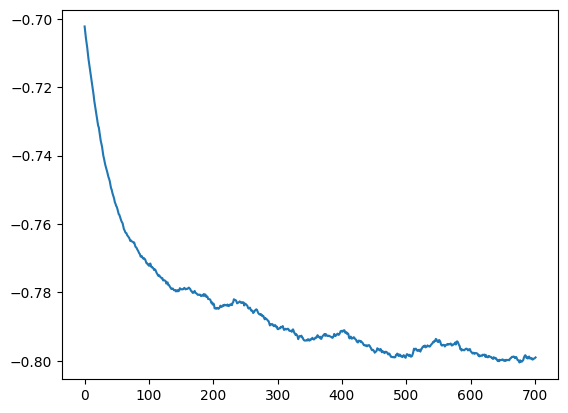

Epoch 900, Loss: (-0.7449365258216858, 0.0228729210793972, -1.99220609664917, 0.2907301187515259)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 131.38781657337745, Squared Error: 171.55137232108825, Abs Error: 187.63913118808705


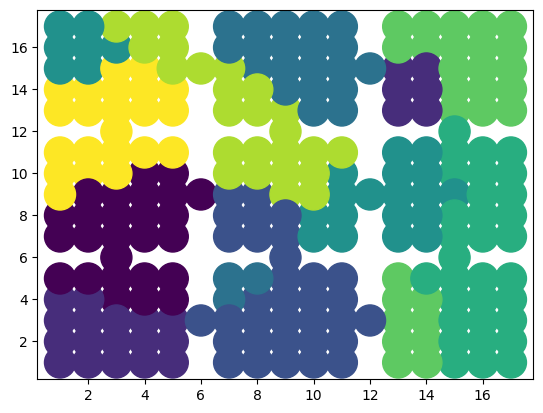

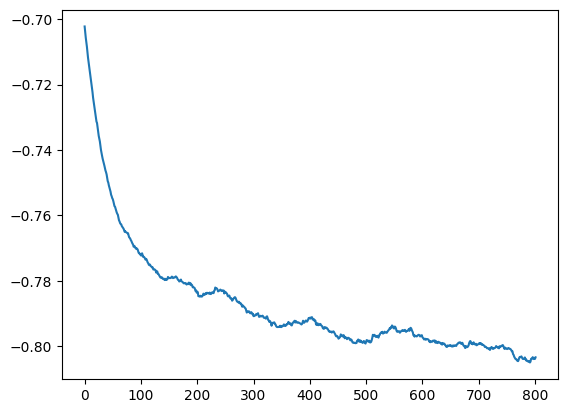

Epoch 1000, Loss: (-0.7771614193916321, 0.011612643487751484, -2.017085075378418, 0.18059957027435303)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 121.81943184140167, Squared Error: 156.50884269601872, Abs Error: 174.23554809717643


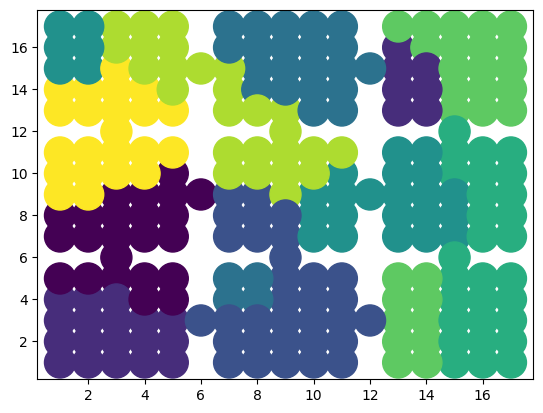

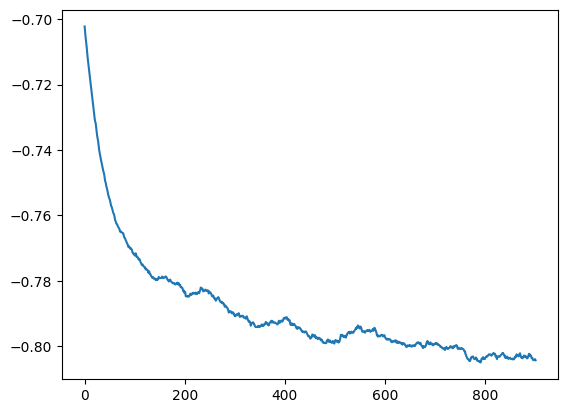

Epoch 1100, Loss: (-0.7946462631225586, 0.00943166483193636, -2.0483434200286865, 0.15259435772895813)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 114.15228521348398, Squared Error: 145.84732707201695, Abs Error: 163.2557315344893


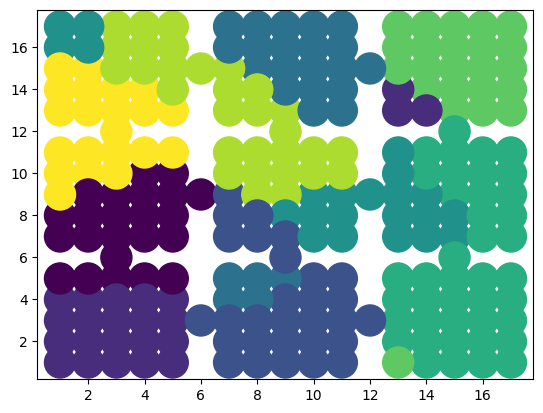

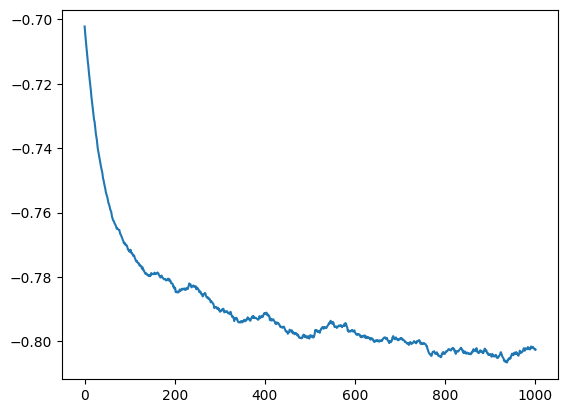

Epoch 1200, Loss: (-0.8080046772956848, 0.02805357612669468, -2.132275104522705, 0.16851794719696045)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 81.86564600155258, Squared Error: 100.85640199578124, Abs Error: 117.54239535640227


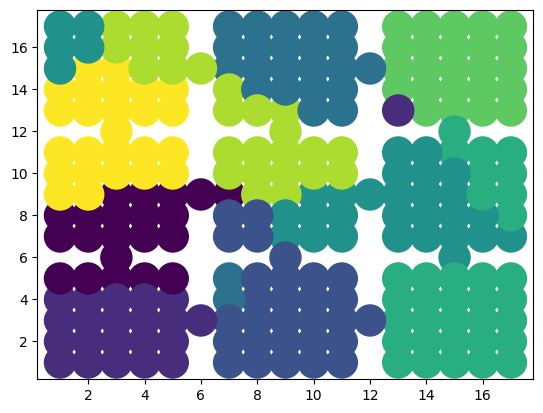

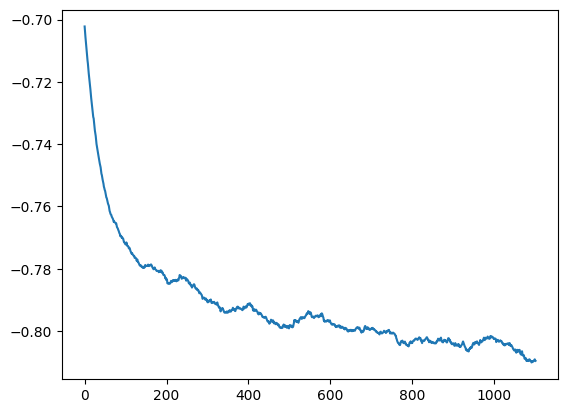

Epoch 1300, Loss: (-0.7608869075775146, 0.016536571085453033, -2.0096006393432617, 0.2641676366329193)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 100.30381280435024, Squared Error: 132.2261734737289, Abs Error: 142.96031192401006


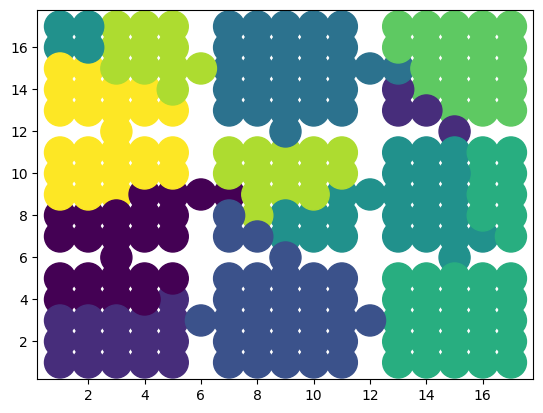

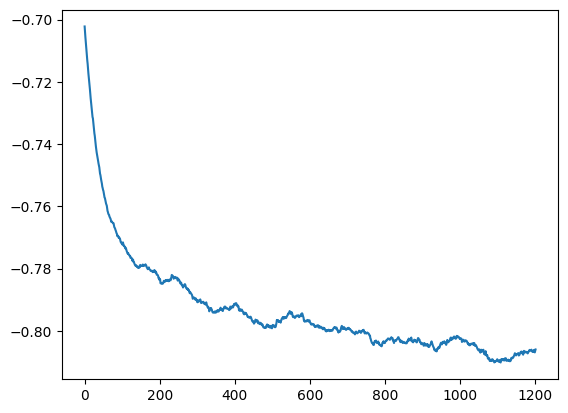

Epoch 1400, Loss: (-0.8322197198867798, 0.012434976175427437, -2.156541109085083, 0.17961791157722473)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 82.28392473627527, Squared Error: 106.05933048302413, Abs Error: 117.50230492202536


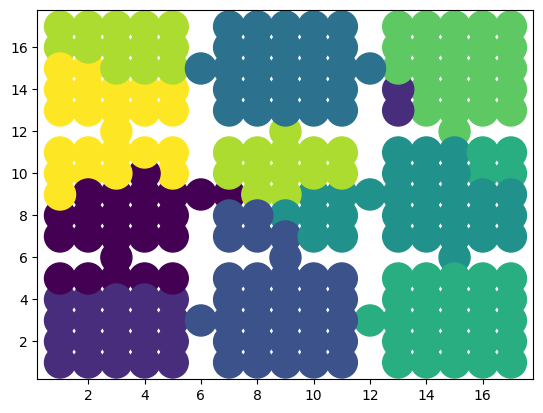

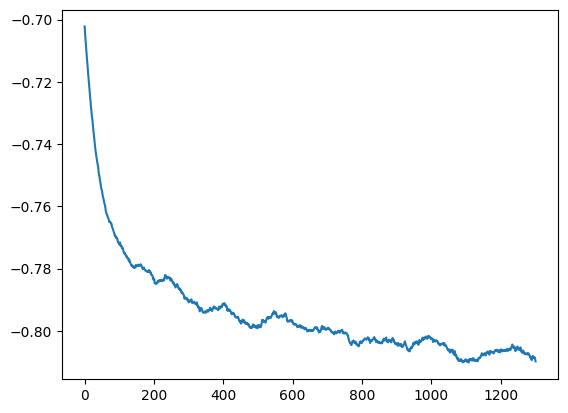

Epoch 1500, Loss: (-0.7826637029647827, 0.008792603388428688, -2.0201761722564697, 0.1661420613527298)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 40.08167207333125, Squared Error: 43.92626885016109, Abs Error: 57.662562180216355


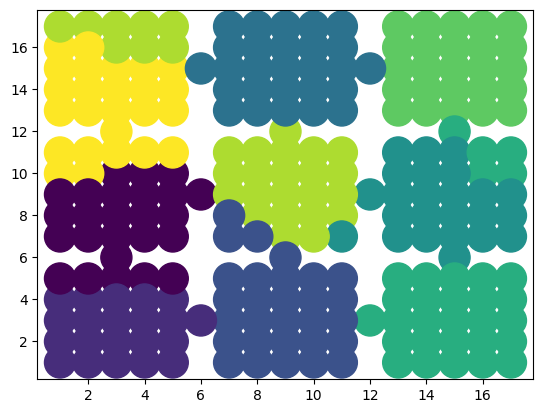

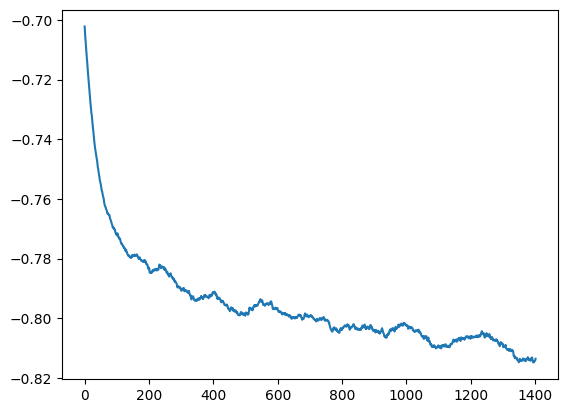

Epoch 1600, Loss: (-0.8177592158317566, 0.008180059492588043, -2.086980104446411, 0.08852799981832504)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 18.64962064422682, Squared Error: 17.552579228424687, Abs Error: 26.896175439376066


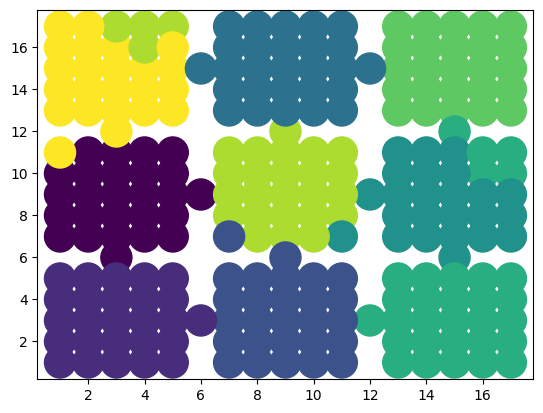

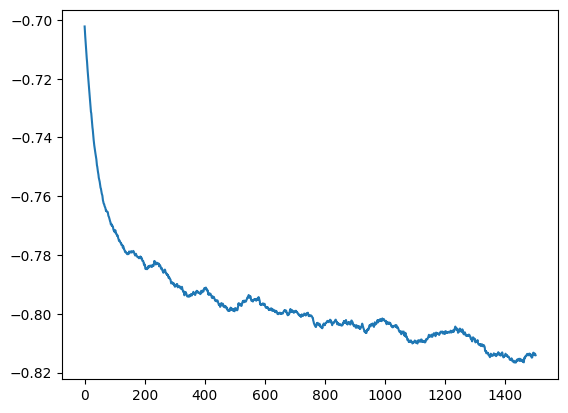

Epoch 1700, Loss: (-0.8115167021751404, 0.005182669032365084, -2.069800853729248, 0.11221010237932205)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 6.962725517957453, Squared Error: 3.8447448516848435, Abs Error: 10.277278152791041


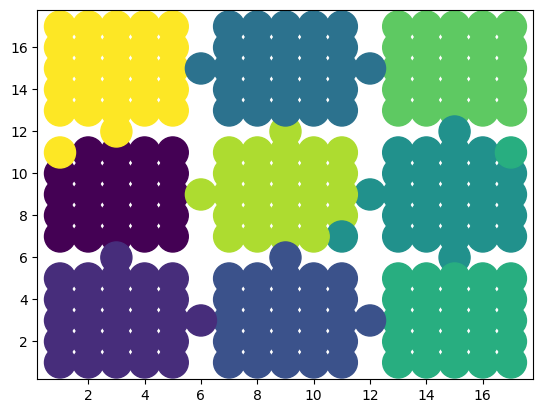

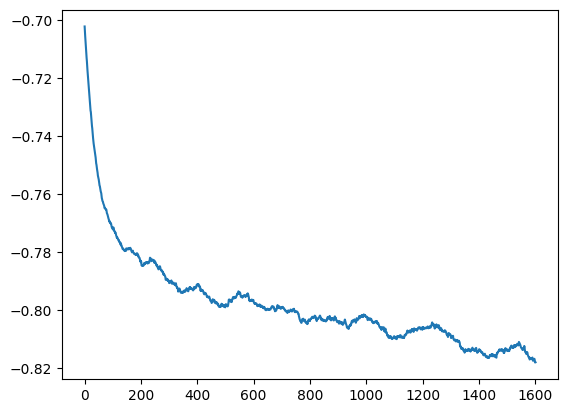

Epoch 1800, Loss: (-0.75827556848526, 0.001879366347566247, -1.9131673574447632, 0.05111974850296974)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 3.433632811600136, Squared Error: 0.8633192794852347, Abs Error: 5.167339204826021


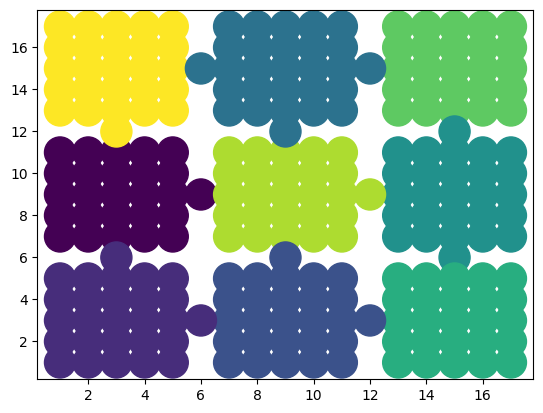

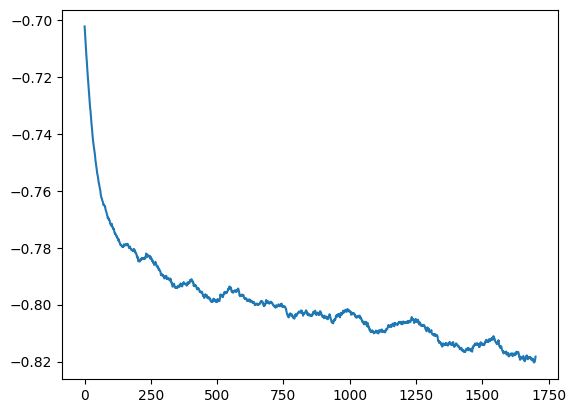

Epoch 1900, Loss: (-0.8276142477989197, 0.0024766516871750355, -2.0910046100616455, 0.06310983747243881)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 7.247202514041558, Squared Error: 4.119319117523743, Abs Error: 10.569032442357639


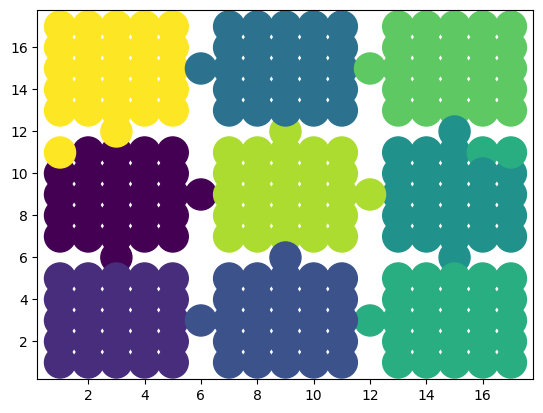

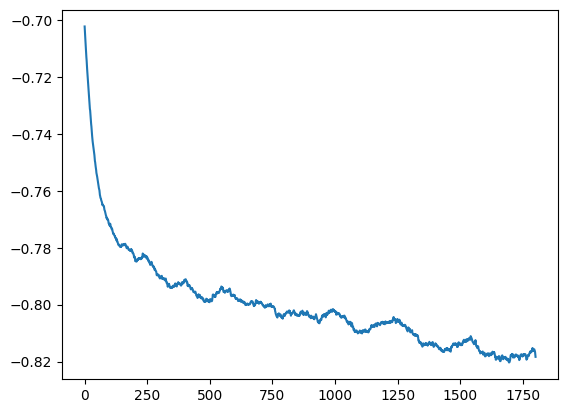

Epoch 2000, Loss: (-0.8486854434013367, 0.0053132884204387665, -2.14947509765625, 0.05791282653808594)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 2.667724396912045, Squared Error: 0.5612792682262939, Abs Error: 3.993073812070179


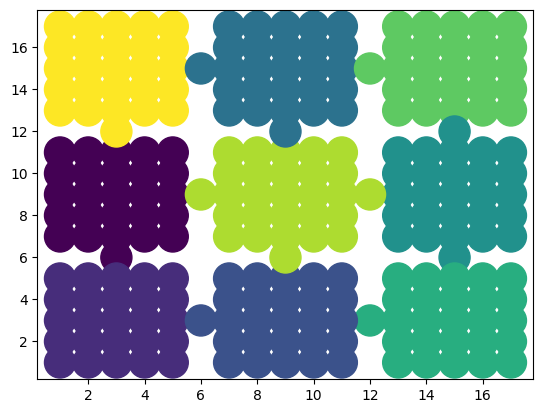

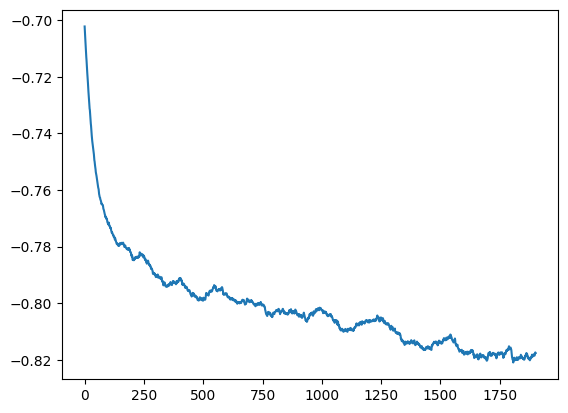

Epoch 2100, Loss: (-0.7775326371192932, 0.009829359129071236, -1.9949932098388672, 0.10635343194007874)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 4.163617259338658, Squared Error: 2.5497706680178878, Abs Error: 6.099231093452772


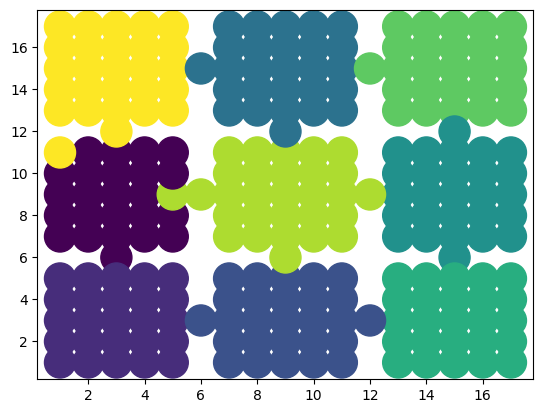

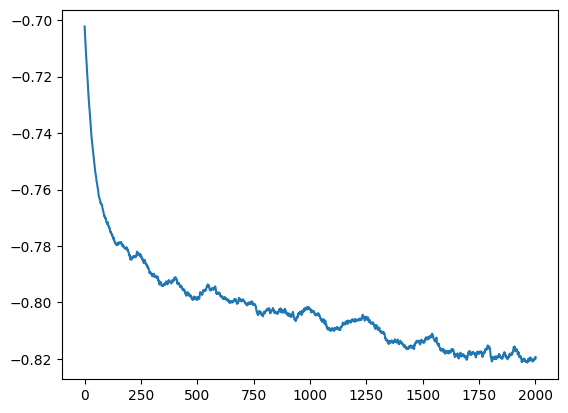

Epoch 2200, Loss: (-0.7712316513061523, 0.0037097190506756306, -1.959006667137146, 0.0866127461194992)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 3.8061043318743675, Squared Error: 1.4295990370310052, Abs Error: 5.607298985534271


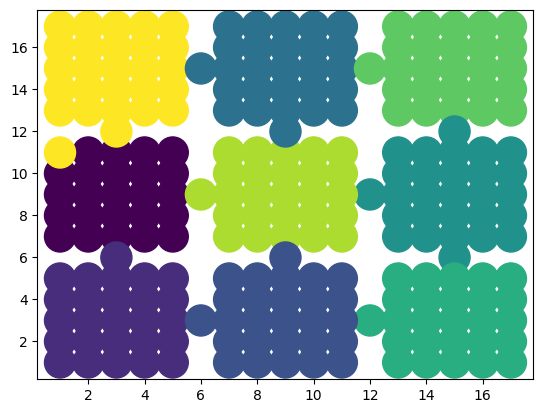

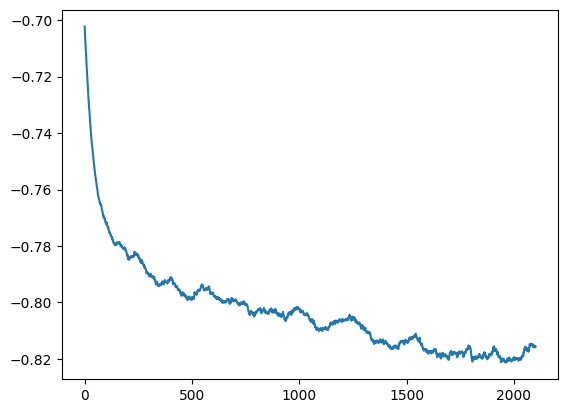

Epoch 2300, Loss: (-0.8555256128311157, 0.0037924847565591335, -2.1612625122070312, 0.051869019865989685)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 4.448530627723802, Squared Error: 2.6581822963360224, Abs Error: 6.470464724106705


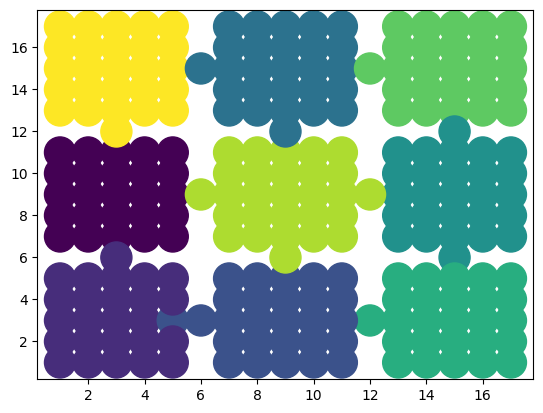

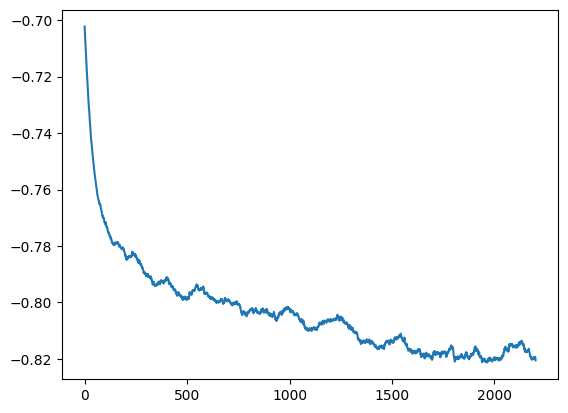

Epoch 2400, Loss: (-0.8232940435409546, 0.006768380291759968, -2.0957581996917725, 0.08240821212530136)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 2.199910909235333, Squared Error: 0.5606556954451317, Abs Error: 3.282701229257782


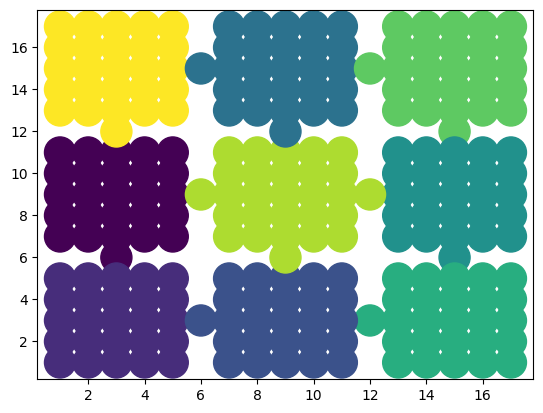

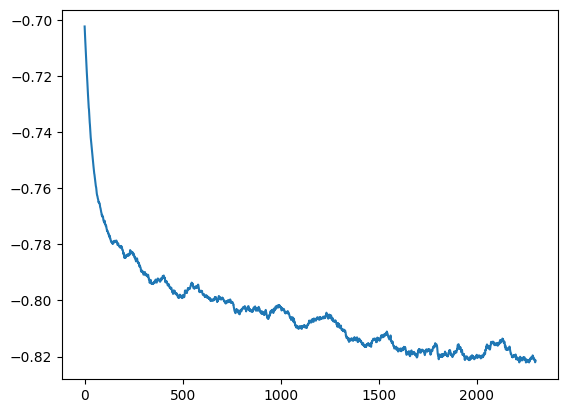

Epoch 2500, Loss: (-0.8406264185905457, 0.003169460454955697, -2.1289408206939697, 0.0778040811419487)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 2.699523389117195, Squared Error: 0.773090888601778, Abs Error: 3.975925449180977


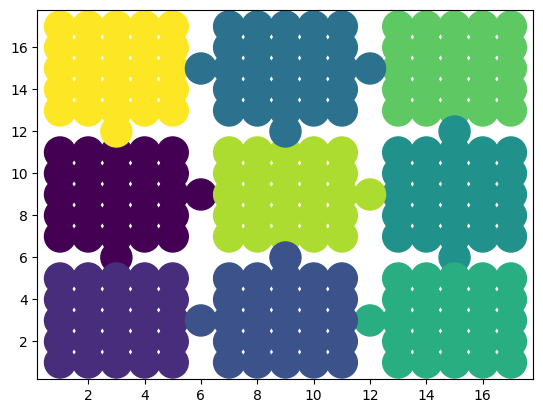

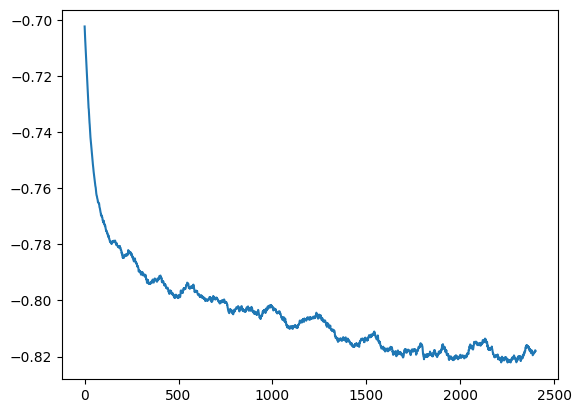

Epoch 2600, Loss: (-0.8043832182884216, 0.0029124717693775892, -2.0315098762512207, 0.053082533180713654)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 1.9969115390217933, Squared Error: 1.1223835820547758, Abs Error: 2.957011275037985


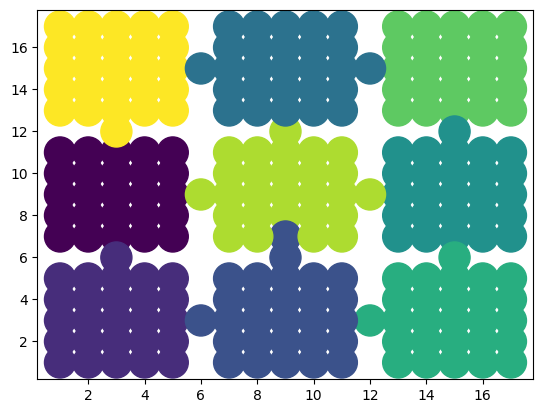

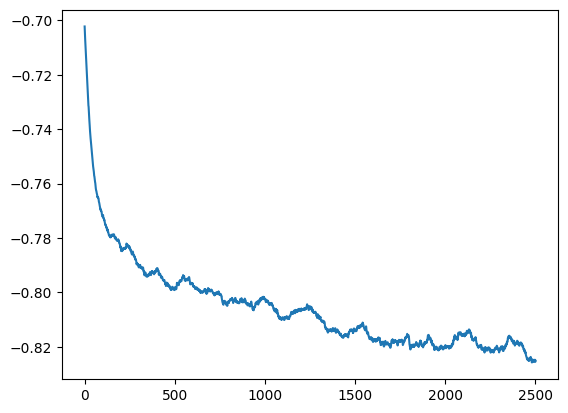

Epoch 2700, Loss: (-0.8271726369857788, 0.006122861988842487, -2.096496343612671, 0.05303017422556877)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 4.283435905999084, Squared Error: 2.711843205382782, Abs Error: 6.223231042115003


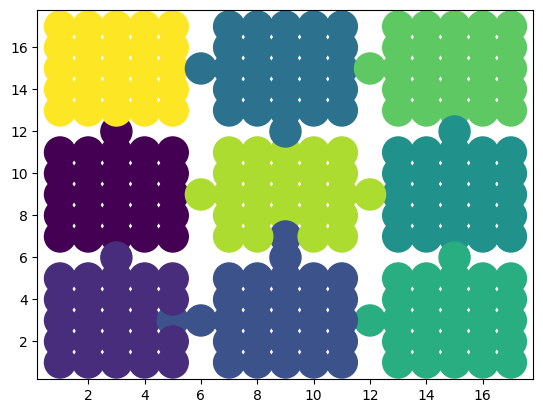

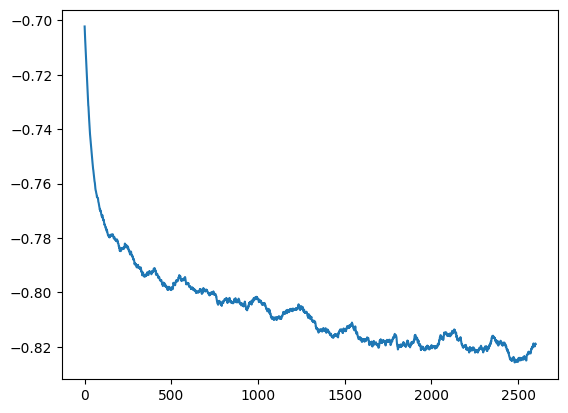

Epoch 2800, Loss: (-0.8277818560600281, 0.009269218891859055, -2.1105616092681885, 0.0717354342341423)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 4.329101330348713, Squared Error: 2.382904486604587, Abs Error: 6.2657053077846285


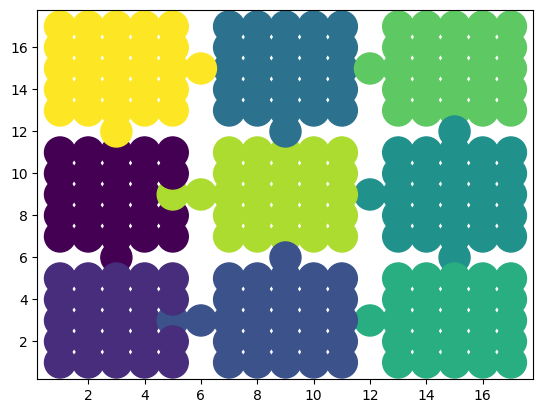

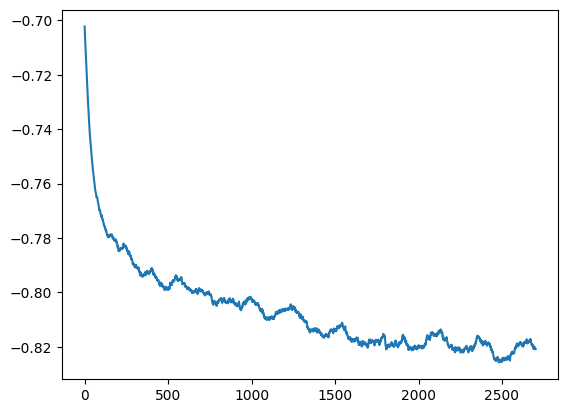

Epoch 2900, Loss: (-0.8538166284561157, 0.003255533054471016, -2.1595730781555176, 0.06757073104381561)


/home/lorenzo/Documents/UPF_projects/HRL-MDP/venv/lib/python3.10/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Error: 2.4633771692654105, Squared Error: 0.46350005886762535, Abs Error: 3.6113526083454417


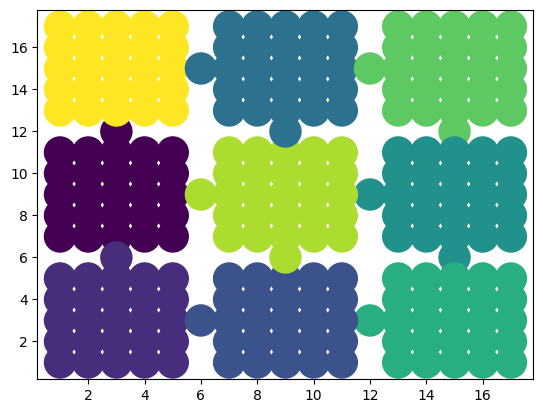

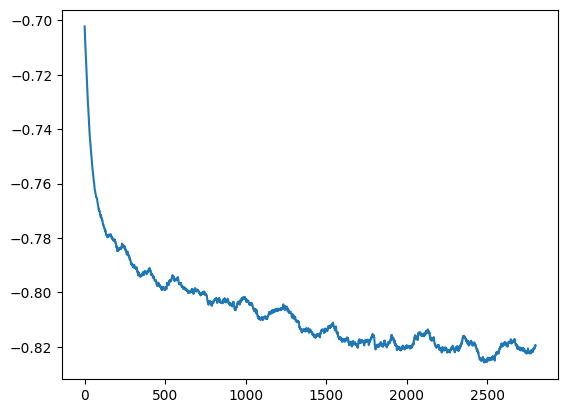

KeyboardInterrupt: 

In [8]:
losses = []
for i in range(config["epochs"]):
    network.train()
    idx, batch_x1, batch_x2, b_is_weights = memory.sample(config["batch_size"])
    x1 = torch.stack(batch_x1)
    x2 = torch.stack(batch_x2)
    z1 = network.pred(x1, 1)
    z2 = network.pred(x2, 1)
    compression_loss = ((-(z1 * z2.log())).sum(axis=1)).mean(axis=0)
    compression_loss = compression_loss / config["batch_size"]
    entropy_loss = (z1.mean(dim=0) * (z1.mean(dim=0).log())).sum()
    det_entropy_loss = (- (z1 * z1.log()).sum(dim=1)).mean()
    loss = config["wl1"] * compression_loss + config["wl2"] * entropy_loss + config["wl3"] * det_entropy_loss
    losses.append(loss.item())
    
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item(), compression_loss.item(), entropy_loss.item(), det_entropy_loss.item()}")
        error, squared_error, abs_error = representation_score(config, network.eval())
        print(f"Error: {error}, Squared Error: {squared_error}, Abs Error: {abs_error}")
        fig = wandb_plot(print_states, annotations, network.eval(), d=2)
        # Draw figure on canvas
        fig.canvas.draw()
        plt.show()
        # moving windows on the losses
        losses_to_plot = np.convolve(losses, np.ones(100)/100, mode='valid')
        # plot the losses graph
        plt.plot(losses_to_plot)
        plt.show()
        
    optimizer.zero_grad()
    loss.backward()
    for param in network.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
